In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


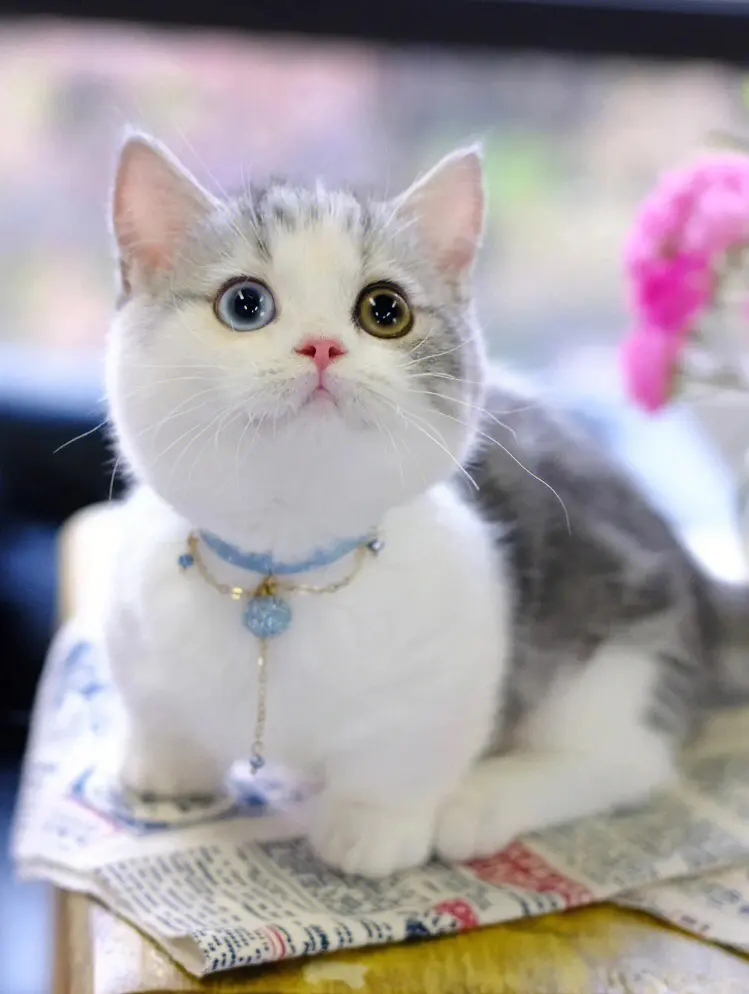

In [2]:
from PIL import Image
pic = Image.open('../pic/cat.png')
display(pic)

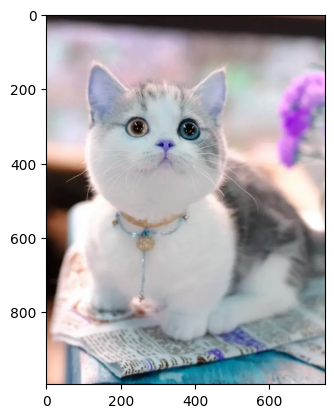

In [3]:
import cv2
pic = cv2.imread('../pic/cat.png')
plt.imshow(pic)
plt.show()

- torchvision.transforms.RandomHorizontalFlip() 
- torchvision.transforms.RandomVerticalFlip()
- torchvision.transforms.RandomResizedCrop
- torchvision.transforms.ColorJitter
- 
- torchvision.transforms.Compose

In [5]:
def show_img(num_rows, num_cols,scale):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(Y[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [6]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(Y[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

img = Image.open('../pic/cat.png')
img.show()


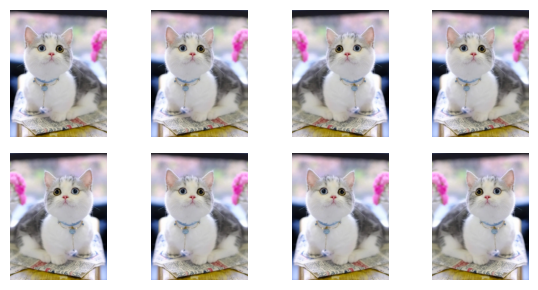

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip())#水平方向随机反转

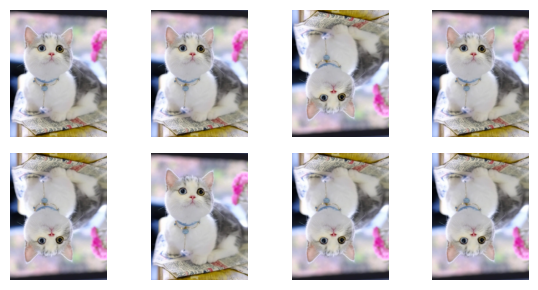

In [8]:
apply(img, torchvision.transforms.RandomVerticalFlip())#垂直翻转

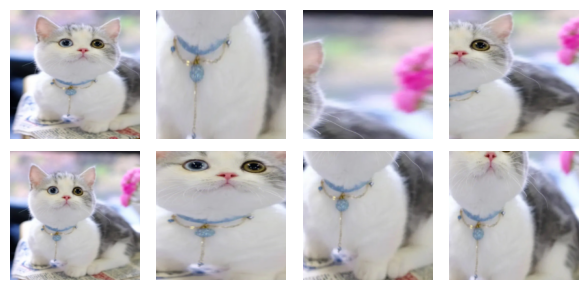

In [9]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))#随机取部分并调整至规定大小
apply(img, shape_aug)

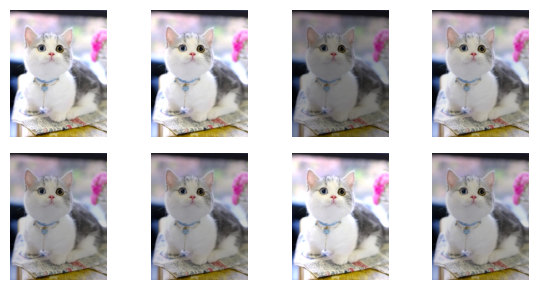

In [10]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))#亮度

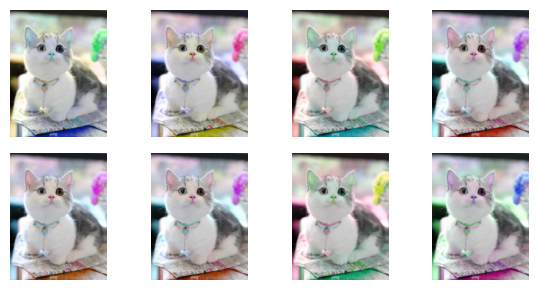

In [11]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))#色相

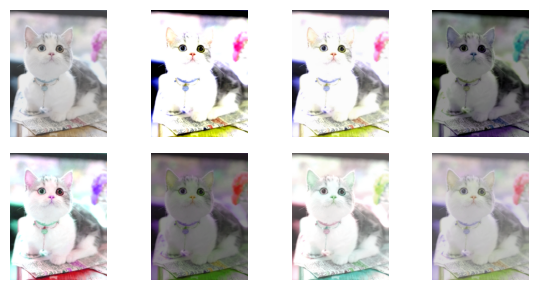

In [12]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)#多个参数一起调
apply(img, color_aug)

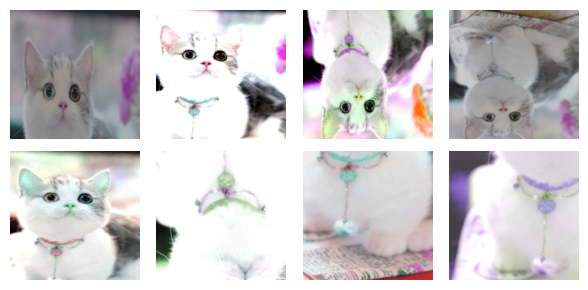

In [13]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    color_aug, shape_aug])#所有策略一起使用
apply(img, augs)

Files already downloaded and verified


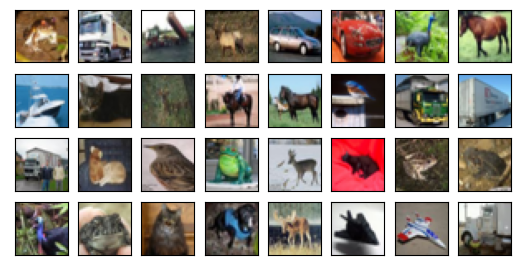

In [26]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root="../data", download=True)
d2l.show_images([
    all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

torchvision.transforms.ToTensor()  
- 数据转换函数
- ToTensor()将输入的图像数据类型转换为torch.FloatTensor  
并将像素值归一化到 [0, 1] 范围内
- 神经网络模型通常期望输入为张量形式，并且经过归一化处理，  
  以便更好地适应网络结构和优化算法的需求。

In [27]:
#训练集做数据增强，测试集不用（但命名仍带‘augs'注意区分）
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),#这里只做水平翻转
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

- torchvision.datasets.CIFAR10
    + 下载标准数据集

- torch.utils.data.DataLoader
    + 输入标准数据集dataset
    + 返回数据加载器dataloader
    + dataloader

dataset：一个标准数据集类
- 根据数据的特点和需求创建自己的数据集类流程：
    + 继承torch.utils.data.Dataset类
    + 实现两个必要方法 _ _len_ _ & _ _getitem_ _

In [28]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="..\data", train=is_train,
              transform=augs, download=True) 
    # is_train指示是否加载训练集True则训练集，False则测试集；
    # augs是之前定义的数据处理方法；
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,num_workers=4)
    # shuffle=is_train 每个epoch数据洗牌
    # num_workers指定用于数据加载的线程数/核数。这里表示使用 4 个线程进行数据加载
    # 返回 dataloader：将创建的数据加载器返回
    return dataloader

- 批次迭代函数**train_batch_ch13**
    - 数据置于GPU上 .to(device)
    - 网络设置训练模式，优化器梯度归零 net.train(); optimizer.zero_grad()
    - 此刻预测值与损失 y_pred = net(X), loss = loss(y_pred, y)
    - 损失反向传播，优化器更新 loss.sum().backward(); optimizer.step()
    - 返回批次准确率与损失率

- **multiple inputs explanation**
    + consieder an example: 2 inputs(image, text sequence)
        - image input tensor:(4,3,224,224) # batchsize4 channels3 imagesize224x224
        - txte sequence input:(4,10,400) # batchsize4 words10 wordembeddings400
    + typically combined into a list or tuple before being passed to the neural network.

In [29]:
#训练函数
def train_batch_ch13(net, X, y, loss, trainer, devices):# trainer:optimizer
    """多GPU，小批量训练"""
        
    if isinstance(X, list): # multiple inputs provided 
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


- **train_ch13**


-  net = nn.DataParallel(net, device_ids=devices).to(devices[0]) 
    + This line wraps the net model with nn.DataParallel to enable multi-GPU training.   
It distributes the model across the specified devices using data parallelism
    + The first device in the devices list is set as the primary device

-  nn.DataParallel
    + split input mini-batches across available GPUs  
    *splits the input mini-batch into smaller sub-batches   
    and assigns each sub-batch to a different GPU*
    + parallelizes the forward pass, backward pass, and gradient computations
    + handle the aggregation of gradients fro mutiple GPUs and   
      update the model parameters 
- parallel process 
    + create the model
    + specify the devices[torch.cuda.device() or d2l.try_gpus():return the list of available devices]
    + wrap the model[model = nn.DataParallel(model, device_ids=devices)]
    + move the model to device[.to(devices[0])]
        - **WHY?**after parallel computation: gradients are then synchronized across   devices and used to update the model parameters
        - **PURPOSE!**Moving the model to the specified device ensures that all operations  associated with the model(backward passes,gradient synchronization...)are executed on that device. This helps avoid any potential inconsistencies or errors that may arise from performing operations across multiple devices simultaneously.
        - **RECOMMENDATION:**devices[0],commonly referred to as the "primary device" 
         responsible for aggregating gradients and updating the model parameters
        - **RECOMMENDATION REASON:**
         Some PyTorch functions and modules assume that the model is on the first device in the list. While it is possible to modify the code to handle different devices, using the first device is generally more straightforward and less error-prone.
        
    + training the model: proceed with training the model as usual


In [ ]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

- nn.CrossEntropyLoss()

- torch.optim.Adam(net.parameters(), lr=lr)

In [30]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)#xavier初始化

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.168, train acc 0.942, test acc 0.838
5683.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


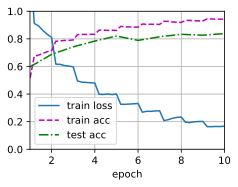

In [31]:
train_with_data_aug(train_augs, test_augs, net)